In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import datetime as dt
import os
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import shuffle
from itertools import product
from sklearn.metrics import mean_squared_error
import ast

In [2]:
# path = './'
# train_queries = pd.read_csv(path + 'train_queries.csv', parse_dates=['req_time'])
# train_plans   = pd.read_csv(path + 'train_plans.csv', parse_dates=['plan_time'])
# train_clicks  = pd.read_csv(path + 'train_clicks.csv')
# profiles      = pd.read_csv(path + 'profiles.csv') 
# test_queries  = pd.read_csv(path + 'test_queries.csv', parse_dates=['req_time'])
# test_plans    = pd.read_csv(path + 'test_plans.csv', parse_dates=['plan_time'])
# weather       = pd.read_csv(path + 'weather.csv')
# lnglat        = pd.read_csv(path + 'lnglat.csv')
# min_sub_d     = pd.read_csv(path + 'min_sub_d.csv',header=None)
# min_sub_o     = pd.read_csv(path + 'min_sub_o.csv',header=None)
# weather       = pd.read_csv(path + 'weather.csv')

In [3]:
def merge_data():
    path = './'
    data   = pd.read_csv(path + 'data_guangzhou.csv', parse_dates=['plan_time','req_time','click_time'])

    return data

In [4]:
def od_feat(pdata):

    pdata['o_lng'] = pdata['o'].apply(lambda x: float(x.split(',')[0]))
    pdata['o_lat'] = pdata['o'].apply(lambda x: float(x.split(',')[1]))
    pdata['d_lng'] = pdata['d'].apply(lambda x: float(x.split(',')[0]))
    pdata['d_lat'] = pdata['d'].apply(lambda x: float(x.split(',')[1])) 
    pdata['od_manhattan_distance'] = abs(pdata['o_lng']-pdata['d_lng'])+abs(pdata['o_lat']-pdata['d_lat'])
    pdata['lon_diff'] = pdata['o_lng'] - pdata['d_lng']
    pdata['lat_diff'] = pdata['o_lat'] - pdata['d_lat']

    return pdata

def time_feat(pdata):
    time_feature = []
    for i in ['req_time']:
        pdata[i + '_minute'] = pdata[i].dt.minute
        pdata[i + '_hour'] = pdata[i].dt.hour
        pdata[i + '_weekday'] = pdata[i].dt.weekday
        time_feature.append(i + '_minute')
        time_feature.append(i + '_hour')
        time_feature.append(i + '_weekday') 

    ispeak_idx_am = (pdata['req_time'].dt.hour >7) &  (pdata['req_time'].dt.hour<9)
    pdata['req_time_ispeak_am'] = 0
    pdata['req_time_ispeak_am'][ispeak_idx_am] = 1
    time_feature.append('req_time_ispeak_am')
    ispeak_idx_pm = (pdata['req_time'].dt.hour >17) &  (pdata['req_time'].dt.hour<19)
    pdata['req_time_ispeak_pm'] = 0
    pdata['req_time_ispeak_pm'][ispeak_idx_pm] = 1
    time_feature.append('req_time_ispeak_pm')
    morning_idx = (pdata['req_time'].dt.hour >6) &  (pdata['req_time'].dt.hour<18)
    pdata['req_time_is_morning'] = 0
    pdata['req_time_is_morning'][morning_idx] = 1
    night_idx = ((pdata['req_time'].dt.hour >=0) &  (pdata['req_time'].dt.hour<=6)) | ((pdata['req_time'].dt.hour >=18) &  (pdata['req_time'].dt.hour<=24))
    pdata['req_time_is_night'] = 0
    pdata['req_time_is_night'][night_idx] = 1
    subway_stop_idx = (pdata['req_time'].dt.hour >5) &  (pdata['req_time'].dt.hour<23)
    pdata['req_time_is_subway_stop'] = 0
    pdata['req_time_is_subway_stop'][subway_stop_idx] = 1
    bus_stop_idx = (pdata['req_time'].dt.hour >5) &  (pdata['req_time'].dt.hour<22)
    pdata['req_time_is_bus_stop'] = 0
    pdata['req_time_is_bus_stop'][bus_stop_idx] = 1
    pdata['time_diff'] = pdata['plan_time'].values.astype(int)-pdata['req_time'].values.astype(int)
    time_feature.append('time_diff')
    pdata['weekend'] = (pdata['req_time_weekday']/5).astype(int)
    time_feature.append('weekend')
    pdata['hour_minute'] = pdata['req_time_hour']*60 +pdata['req_time_minute']
    time_feature.append('hour_minute')
    pdata['first_workday'] = (pdata['req_time_weekday'] == 0).astype(int)
    pdata['last_workday'] = (pdata['req_time_weekday'] == 4).astype(int)

    pdata['req_min_seg'] = ((pdata['req_time_minute'] + 30) / 60).astype(int)    

    return pdata, time_feature

In [5]:
def gen_plan_feas(data):
    n                                           = data.shape[0]
    mode_list_feas                              = np.zeros((n, 12))
    max_dist, min_dist, mean_dist, std_dist     = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta         = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode, = \
    np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)),
    
    max_speed, min_speed, max_pd, min_pd, std_speed, std_pd, mean_speed, mean_pd = \
           np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    
    max_pe, min_pe, mean_pe, std_pe = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    second_mode,max_speed_mode,min_speed_mode = np.zeros((n,)),np.zeros((n,)),np.zeros((n,))
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] =  1
            first_mode[i]        =  0
            second_mode[i]       = -1
            max_pe[i]            = -1
            min_pe[i]            = -1
            mean_pe[i]           = -1
            std_pe[i]            = -1
            max_speed[i]         = -1
            min_speed[i]         = -1
            std_speed[i]         = -1
            mean_speed[i]        = -1
            max_pd[i]            = -1
            min_pd[i]            = -1
            std_pd[i]            = -1
            mean_pd[i]           = -1
            max_dist[i]          = -1
            min_dist[i]          = -1
            mean_dist[i]         = -1
            std_dist[i]          = -1
            max_price[i]         = -1
            min_price[i]         = -1
            mean_price[i]        = -1
            std_price[i]         = -1
            max_eta[i]           = -1
            min_eta[i]           = -1
            mean_eta[i]          = -1
            std_eta[i]           = -1
            min_dist_mode[i]     = -1
            max_dist_mode[i]     = -1
            min_speed_mode[i]     = -1
            max_speed_mode[i]     = -1
            min_price_mode[i]    = -1
            max_price_mode[i]    = -1
            min_eta_mode[i]      = -1
            max_eta_mode[i]      = -1
            mode_texts.append('word_null')
        else:
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))
            mode_arr = np.array(mode_list, dtype='int')
            distance_list                = np.array(distance_list)
            price_list                   = np.array(price_list)
            eta_list                     = np.array(eta_list)
            mode_list                    = np.array(mode_list, dtype='int')
            mode_list_feas[i, mode_list] = 1
            distance_sort_idx            = np.argsort(distance_list)
            price_sort_idx               = np.argsort(price_list)
            eta_sort_idx                 = np.argsort(eta_list)
            speed_sort_idx               = np.argsort((np.array(distance_list)/np.array(eta_list)).tolist())
            max_dist[i]                  = distance_list[distance_sort_idx[-1]]
            min_dist[i]                  = distance_list[distance_sort_idx[0]]
            max_speed[i]                 = (np.array(distance_list)/np.array(eta_list)).max() 
            min_speed[i]                 = (np.array(distance_list)/np.array(eta_list)).min()
            mean_speed[i]                = np.mean((np.array(distance_list)/np.array(eta_list)).tolist())
            std_speed[i]                 = np.std((np.array(distance_list)/np.array(eta_list)).tolist())
            max_pd[i]                    = (np.array(price_list)/np.array(distance_list)).max()
            min_pd[i]                    = (np.array(price_list)/np.array(distance_list)).min()
            mean_pd[i]                   = np.mean((np.array(price_list)/np.array(distance_list)).tolist())
            std_pd[i]                    = np.std((np.array(price_list)/np.array(distance_list)).tolist())
            max_pe[i]                    = (np.array(price_list)/np.array(eta_list)).max()
            min_pe[i]                    = (np.array(price_list)/np.array(eta_list)).min()
            mean_pe[i]                   = np.mean((np.array(price_list)/np.array(eta_list)).tolist())
            std_pe[i]                    = np.std((np.array(price_list)/np.array(eta_list)).tolist())
            mean_dist[i]                 = np.mean(distance_list)
            std_dist[i]                  = np.std(distance_list)
            max_price[i]                 = price_list[price_sort_idx[-1]]
            min_price[i]                 = price_list[price_sort_idx[0]]
            mean_price[i]                = np.mean(price_list)
            std_price[i]                 = np.std(price_list)
            max_eta[i]                   = eta_list[eta_sort_idx[-1]]
            min_eta[i]                   = eta_list[eta_sort_idx[0]]
            mean_eta[i]                  = np.mean(eta_list)
            std_eta[i]                   = np.std(eta_list)
            first_mode[i]                = mode_list[0]
            if len(mode_arr) < 2:
                second_mode[i] = -1
            else:
                second_mode[i] = mode_arr[1]
            max_dist_mode[i]             = mode_list[distance_sort_idx[-1]]
            min_dist_mode[i]             = mode_list[distance_sort_idx[0]]
            max_price_mode[i]            = mode_list[price_sort_idx[-1]]
            min_price_mode[i]            = mode_list[price_sort_idx[0]]
            max_eta_mode[i]              = mode_list[eta_sort_idx[-1]]
            min_eta_mode[i]              = mode_list[eta_sort_idx[0]]
            max_speed_mode[i]            = mode_list[speed_sort_idx[-1]]
            min_speed_mode[i]            = mode_list[speed_sort_idx[0]]
    feature_data                   =  pd.DataFrame(mode_list_feas)
    feature_data.columns           =  ['mode_feas_{}'.format(i) for i in range(12)]
    feature_data['max_dist']       =  max_dist
    feature_data['min_dist']       =  min_dist
    feature_data['mean_dist']      =  mean_dist
    feature_data['std_dist']       =  std_dist
    feature_data['max_price']      = max_price
    feature_data['min_price']      = min_price
    feature_data['mean_price']     = mean_price
    feature_data['std_price']      = std_price
    feature_data['max_eta']        = max_eta
    feature_data['min_eta']        = min_eta
    feature_data['mean_eta']       = mean_eta
    feature_data['std_eta']        = std_eta
    feature_data['max_dist_mode']  = max_dist_mode
    feature_data['min_dist_mode']  = min_dist_mode
    feature_data['max_price_mode'] = max_price_mode
    feature_data['min_price_mode'] = min_price_mode
    feature_data['max_speed_mode'] = max_price_mode
    feature_data['min_speed_mode'] = min_price_mode
    feature_data['max_eta_mode']   = max_eta_mode
    feature_data['min_eta_mode']   = min_eta_mode
    feature_data['first_mode']     = first_mode
    feature_data['max_speed']      = max_speed
    feature_data['min_speed']      = min_speed
    feature_data['mean_speed']     = mean_speed
    feature_data['std_speed']      = std_speed
    feature_data['max_pd']         = max_pd
    feature_data['min_pd']         = min_pd
    feature_data['mean_pd']        = mean_pd
    feature_data['std_pd']         = std_pd
    feature_data['max_pe']         = max_pe
    feature_data['min_pe']         = min_pe
    feature_data['mean_pe']         = mean_pe
    feature_data['std_pe']         = std_pe
    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=20, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_{}'.format(i) for i in range(20)]
    plan_fea = pd.concat([feature_data, mode_svd], axis=1)
    plan_fea['sid'] = data['sid'].values
    print("Done")
    return plan_fea

In [6]:
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True


In [7]:
def od_svd_feat(pdata):
    # od
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    #
    lbl_enc = LabelEncoder()
    pdata['olbl'] = lbl_enc.fit_transform(pdata['o'])
    lbl_enc = LabelEncoder()
    pdata['dlbl'] = lbl_enc.fit_transform(pdata['d'])
    lbl_enc = LabelEncoder()
    pdata['pidlbl'] = lbl_enc.fit_transform(pdata['pid'])
    # 
    onehot_enc = OneHotEncoder()
    o_tmp = onehot_enc.fit_transform(pdata['olbl'].values.reshape(-1,1))
    onehot_enc = OneHotEncoder()
    d_tmp = onehot_enc.fit_transform(pdata['dlbl'].values.reshape(-1,1))
    onehot_enc = OneHotEncoder()
    pid_tmp = onehot_enc.fit_transform(pdata['pidlbl'].values.reshape(-1,1))
    #
    svd = TruncatedSVD(n_components=30, n_iter=20, random_state=47)
    o_svd = svd.fit_transform(o_tmp)
    svd = TruncatedSVD(n_components=30, n_iter=20, random_state=47)
    d_svd = svd.fit_transform(d_tmp)
    svd = TruncatedSVD(n_components=100, n_iter=20, random_state=47)
    pid_svd = svd.fit_transform(pid_tmp)

    o_cols = ['o_svd_{}'.format(i) for i in range(30)]
    d_cols = ['d_svd_{}'.format(i) for i in range(30)]
    pid_cols = ['pid_svd_{}'.format(i) for i in range(100)]
    o_df = pd.DataFrame(o_svd, columns=o_cols)
    d_df = pd.DataFrame(d_svd, columns=d_cols)
    pid_df = pd.DataFrame(pid_svd, columns=pid_cols)
    pdata = pd.concat([pdata, o_df], axis=1)
    pdata = pd.concat([pdata, d_df], axis=1)
    pdata = pd.concat([pdata, pid_df], axis=1)
    return pdata

In [8]:
def construct_plan_feature_II(fdata):
    n = fdata.shape[0]
    max_price, max_dist, max_eta = np.zeros((n,)),np.zeros((n,)),np.zeros((n,))
    mode_feature = np.full((n,143), np.nan)
    ps = ['distance', 'price', 'eta']
    for i, plan in tqdm(enumerate(fdata['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list = []
            continue
        else:
            cur_plan_list = plan
        if len(cur_plan_list) == 0:
            price_list[i] = -1
            distance_list[i] = -1
            eta_list[i] = -1
        else:
            price_list = []
            distance_list = []
            eta_list = []
            for tmp_dit in cur_plan_list:             
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
            distance_list = np.array(distance_list)
            eta_list      = np.array(eta_list)
            price_list    = np.array(price_list)
            distance_sort_idx   = np.argsort(distance_list)
            price_sort_idx      = np.argsort(price_list)
            eta_sort_idx        = np.argsort(eta_list)
            max_dist[i] = distance_list[distance_sort_idx[-1]]
            max_eta [i] = eta_list[eta_sort_idx[-1]]
            max_price[i]= price_list[price_sort_idx[-1]]
        # {'1':{'distance': [], 'price':[], 'eta':[]}}
        mode_dict = {}
        # mode_dict
        for tmp_dict in plan:
            m = tmp_dict['transport_mode']
            if m not in mode_dict:
                one_dict = {}
                for p in ps:
                    one_dict[p] = []
                mode_dict[m] = one_dict
            for p in ps:
                mode_dict[m][p].append(0 if tmp_dict[p] == '' else int(tmp_dict[p]))


        rank = 0
        total_distance = 0
        total_price = 0
        total_eta = 0
        for m, v in mode_dict.items():
            rank += 1
            m = int(m)
            distance = np.array(v['distance']).mean()
            price = np.array(v['price']).mean()
            eta = np.array(v['eta']).mean()
            mode_feature[i, 13*(m-1)] = distance
            mode_feature[i, 13*(m-1)+1] = price
            mode_feature[i, 13*(m-1)+2] = eta
            mode_feature[i, 13*(m-1)+3] = distance / eta
            mode_feature[i, 13*(m-1)+4] = price / distance
            mode_feature[i, 13*(m-1)+5] = price / eta
            mode_feature[i, 13*(m-1)+6] = rank
            mode_feature[i, 13*(m-1)+7] = distance / max_dist[i]
            mode_feature[i, 13*(m-1)+8] = price / max_price[i]
            mode_feature[i, 13*(m-1)+9] = eta   / max_eta[i]
            
        for m, v in mode_dict.items():
            m = int(m)
            distance = np.array(v['distance']).mean()
            price = np.array(v['price']).mean()
            eta = np.array(v['eta']).mean()
            mode_feature[i, 13*(m-1)+10] = distance / total_distance
            mode_feature[i, 13*(m-1)+11] = price / total_price
            mode_feature[i, 13*(m-1)+12] = eta / total_eta

        
    cols = []
    for i in range(1, 12):
        for p in ps:
            cols.append('mode_' + str(i) + '_' + p)
        cols.append('mode_' + str(i) + '_speed')
        cols.append('mode_' + str(i) + '_p/d')
        cols.append('mode_' + str(i) + '_rank')
        cols.append('mode_' + str(i) + '_p/e')
        cols.append('mode_' + str(i) + 'd/max_d')
        cols.append('mode_' + str(i) + 'p/max_p')
        cols.append('mode_' + str(i) + 'e/max_e')
        cols.append('mode_' + str(i) + '_distance_ratio')
        cols.append('mode_' + str(i) + '_price_ratio')
        cols.append('mode_' + str(i) + '_eta_ratio')
        
    mode_feature_df = pd.DataFrame(mode_feature, columns=cols)
    mode_feature_df['sid'] = fdata['sid'].values
    print("Done")
    return mode_feature_df

In [9]:
def p_cross_feat(pdata):
    path = './'
    pprofiles = pd.read_csv(path + 'profiles.csv') 
    p1 = pd.DataFrame()
    p2 = pd.DataFrame()
    for i in range(1,len(pprofiles.columns)-1):
        if i%2 == 0:
            p1=pd.concat([p1,pprofiles['p{}'.format(i)]],axis=1)
        else:
            p2=pd.concat([p2,pprofiles['p{}'.format(i)]],axis=1)

    p1.columns = ['p_' + str(i) for i in range(32)]
    p2.columns = ['p_' + str(i) for i in range(33)]
    res = (p1+p2)
    res.drop(['p_32'],inplace=True,axis=1)
    res.columns = ['p_' + str(i) for i in range(32)]
    res['pid'] = pprofiles['pid']
    pdata  = pdata.merge(res, 'left', ['pid']) 
    return pdata

In [10]:
def gen_exp_data():
    data = merge_data()
    data = od_feat(data)
    data, time_feature = time_feat(data)
    data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
    data_plans = gen_plan_feas(data)
    plan_features = [col for col in data_plans.columns if col not in ['sid']]
    data = data.merge(data_plans, on='sid', how='left')
    data_plans_II = construct_plan_feature_II(data)
    plan_features_II = [col for col in data_plans_II.columns if col not in ['sid']]
    data = data.merge(data_plans_II, on='sid', how='left')

    data['pid'] = data['pid'].fillna(-1)

    data = od_svd_feat(data)
    data = p_cross_feat(data)
    data = od_feat(data)

    print("All Done")
    return data,plan_features,plan_features_II

data,plan_features,plan_features_II = gen_exp_data()

569074it [02:29, 3816.57it/s]


mode tfidf...
Done


569074it [02:16, 4180.77it/s]


Done
All Done


In [11]:
extra = pd.read_csv('./extra.csv')
extra_I = pd.read_csv('./extra_I.csv')
data = data.merge(extra, on='o',how='left')
data = data.merge(extra_I, on='d',how='left')
extra.head()

,o,tube_stops_o,car_prob_o
0,"116.34,39.99",0,166
1,"116.43,39.94",1,319
2,"116.28,40.01",0,74
3,"116.31,39.51",0,22
4,"116.33,39.89",1,0


In [34]:
import gc
del data

gc.collect()

7

In [12]:
profile_feature = ['p' + str(i) for i in range(66)]
p_cross_feature = ['p_' + str(i) for i in range(32)]
pid_cols = ['pid_svd_{}'.format(i) for i in range(100)]
o_cols = ['o_svd_{}'.format(i) for i in range(20)]
d_cols = ['d_svd_{}'.format(i) for i in range(20)]
time_feature = ['req_min_seg','first_workday','last_workday','req_time_minute', 'req_time_hour', 'req_time_weekday', 'time_diff','weekend',
                'hour_minute','req_time_ispeak_am','req_time_ispeak_pm','req_time_is_morning',
                'req_time_is_night','req_time_is_subway_stop','req_time_is_bus_stop']
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat','od_manhattan_distance'] #+ profile_feature
test_feature = ['lon_diff','lat_diff','tube_stops_d','car_prob_d','tube_stops_o','car_prob_o']
feature = origin_num_feature+plan_features+plan_features_II+profile_feature+p_cross_feature+o_cols+d_cols+pid_cols+time_feature+test_feature
train_index = (data.req_time >= '2018-10-1') &(data.req_time < '2018-11-24')
train_x = data[train_index][feature].reset_index(drop=True)
train_y = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time >= '2018-11-24') &(data.req_time < '2018-12-01')
valid_x =data[valid_index][feature].reset_index(drop=True)
valid_y =data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time >= '2018-12-01')
test_x = data[test_index][feature].reset_index(drop=True)

print(len(feature),feature)

472 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'od_manhattan_distance', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_speed_mode', 'min_speed_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'max_speed', 'min_speed', 'mean_speed', 'std_speed', 'max_pd', 'min_pd', 'mean_pd', 'std_pd', 'max_pe', 'min_pe', 'mean_pe', 'std_pe', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9', 'svd_mode_10', 'svd_mode_11', 'svd_mode_12', 'svd_mode_13', 'svd_mode_14', 'svd_mode_15', 'svd_mode_16', 'svd_mode_17', 'svd_mode_18', 'svd_mode_19', 'mode_1_distance', 'mode_1_p

In [13]:
test = ['click_mode','req_time']
train1_index = ((data.req_time >= '2018-10-01') &(data.req_time < '2018-11-24'))
feature_x = feature+test
train_1 = data[train1_index][feature_x].reset_index(drop=True)
c3 = train_1.loc[train_1['click_mode']==3.0]
c4 = train_1.loc[train_1['click_mode']==4.0]
c6 = train_1.loc[train_1['click_mode']==6.0]
c8 = train_1.loc[train_1['click_mode']==8.0]
# tmp = pd.DataFrame()
# tmp = pd.concat([tmp,c4,c4,c4,c3,c3,c6,c6],axis=0)
# tmp = shuffle(tmp, random_state=47)
# train_1 = pd.concat([train_1, tmp], axis=0)
train_1 = pd.concat([train_1,c4,c4,c4,c3,c3,c6,c6],axis=0)
train1_index = (train_1.req_time < '2018-11-24')
train_x = train_1[train1_index][feature].reset_index(drop=True)
train_y = train_1[train1_index].click_mode.reset_index(drop=True)
# train_X = train_x[train_x['time_diff']<500]
# train_Y = train_y[train_x['time_diff']<500]

In [14]:
import time
t0 = time.time()
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=52, reg_alpha=0.1, reg_lambda=1,
                                max_depth=-1, n_estimators=5000, objective='multiclass',sub_feature=0.8,
                                subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples=50,  
                               learning_rate=0.1, random_state=2019, metric="None",n_jobs=-1,device='gpu')
eval_set = [(valid_x, valid_y)]

lgb_model.fit(train_x, train_y, eval_set=eval_set,eval_metric=f1_weighted,verbose=10, early_stopping_rounds=50)#0.698428
t1 = time.time()
#0.7308
print('lgb process elapse time: {}'.format(t1-t0))

Training until validation scores don't improve for 50 rounds.
[10]	valid_0's f1_weighted: 0.715997
[20]	valid_0's f1_weighted: 0.718037
[30]	valid_0's f1_weighted: 0.718688
[40]	valid_0's f1_weighted: 0.719043
[50]	valid_0's f1_weighted: 0.718955
[60]	valid_0's f1_weighted: 0.71896
[70]	valid_0's f1_weighted: 0.718861
[80]	valid_0's f1_weighted: 0.718863
[90]	valid_0's f1_weighted: 0.718929
[100]	valid_0's f1_weighted: 0.719227
[110]	valid_0's f1_weighted: 0.719271
[120]	valid_0's f1_weighted: 0.719156
[130]	valid_0's f1_weighted: 0.718986
[140]	valid_0's f1_weighted: 0.719011
[150]	valid_0's f1_weighted: 0.718709
[160]	valid_0's f1_weighted: 0.718675
Early stopping, best iteration is:
[111]	valid_0's f1_weighted: 0.719296
lgb process elapse time: 177.7130103111267


In [42]:
imp = pd.DataFrame()
imp['fea'] = train_x.columns
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp.head(10)

NotFittedError: No booster found. Need to call fit beforehand.

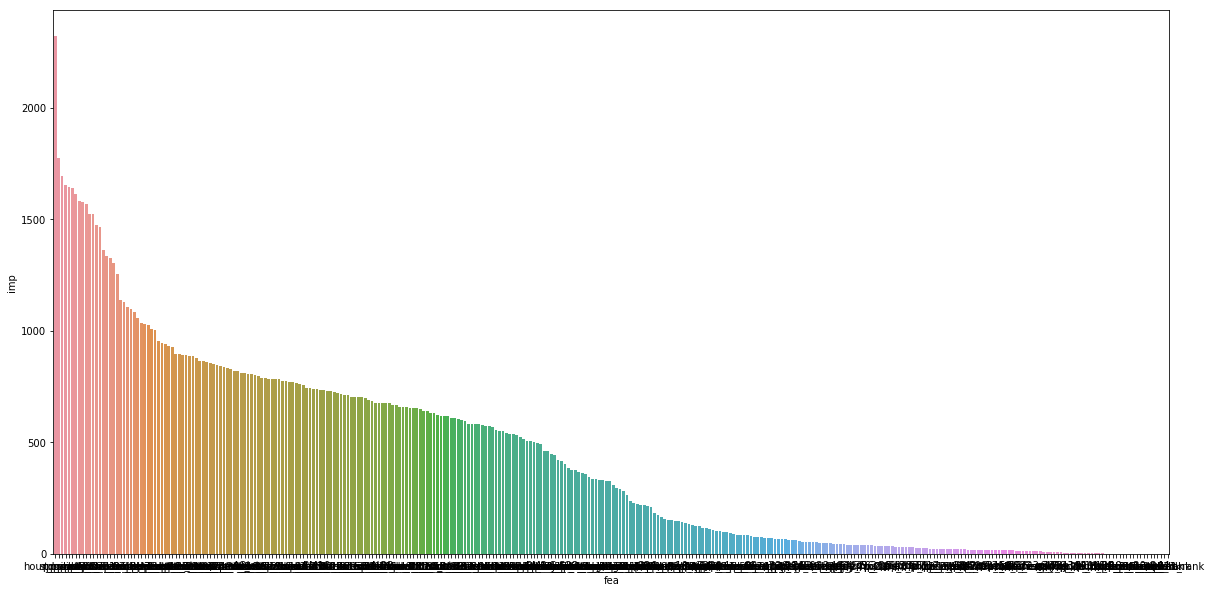

In [157]:
plt.figure(figsize=[20,10])
sns.barplot(x = 'fea', y ='imp',data = imp)

In [70]:
pred = lgb_model.predict(valid_x) 
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
    print(f_score)
get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])

0 0.08768752286864252 0.35765673175745116 0.999043062200957 0.21781765074066348
1 0.14617636297109404 0.6808049162549705 0.6563661710037175 0.7071339173967459
2 0.31163556531284303 0.9015426371617692 0.8533529072510879 0.9555007631795233
3 0.04399926820343945 0.2185430463576159 0.2534284147010422 0.1920997920997921
4 0.02420417124039517 0.14702044367116135 0.17315573770491804 0.12773998488284202
5 0.09851811196487377 0.8457423485047795 0.801262878032569 0.8954503249767873
6 0.01995975118916941 0.22786121180735372 0.2619047619047619 0.2016498625114574
7 0.17588730332967434 0.7863982437292727 0.7136922424756252 0.8755980861244019
8 0.004793267471642883 0.23979591836734698 0.36153846153846153 0.17938931297709923
9 0.05124405415294548 0.5290375538682537 0.622104247104247 0.46019278828989646
10 0.028594950603732162 0.5652781660609449 0.5019860973187686 0.6468330134357005
11 0.00729967069154775 0.45112781954887216 0.5639097744360902 0.37593984962406013
0.6989096905893715


In [15]:
train2_index = ((data.req_time >= '2018-10-01') &(data.req_time <'2018-12-01'))
train_2 = data[train2_index][feature_x].reset_index(drop=True)
c3 = train_2.loc[train_2['click_mode']==3.0]
c4 = train_2.loc[train_2['click_mode']==4.0]
c6 = train_2.loc[train_2['click_mode']==6.0]
# tmp1= pd.DataFrame()
# tmp1 = pd.concat([tmp1,c4,c4,c4,c3,c3,c6,c6],axis=0)
# tmp1 = shuffle(tmp1)
# train_2 = pd.concat([train_2, tmp1], axis=0)
train_2 = pd.concat([train_2,c4,c4,c4,c3,c3,c6,c6],axis=0)
train2_index = (train_2.req_time <'2018-12-01')
all_train_x = train_2[train2_index][feature].reset_index(drop=True)
all_train_y = train_2[train2_index].click_mode.reset_index(drop=True)
#all_train_X = all_train_x[all_train_x['time_diff']<500]
#all_train_Y = all_train_y[all_train_x['time_diff']<500]

In [36]:
data =merge_data()

In [16]:
print(lgb_model.best_iteration_)
lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y,verbose=10)
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result['recommend_mode'] = lgb_model.predict(test_x)
result['recommend_mode'] = result['recommend_mode'].astype(int)
print(len(result))
print(result['recommend_mode'].value_counts())
result[['sid', 'recommend_mode']].to_csv('./CAMM_guangzhou.csv', index=False)

111
fit over
68983
2     18397
7     11545
9     11101
1     10867
5      8943
0      1942
11     1910
10     1364
6      1120
3       949
4       717
8       128
Name: recommend_mode, dtype: int64


In [37]:
from hyperopt import fmin, tpe, hp, partial
from sklearn.metrics import mean_squared_error

train_data = lgb.Dataset(data=train_x,label=train_y)
test_data = lgb.Dataset(data=valid_x,label=valid_y)

# 自定义hyperopt的参数空间
space = {"max_depth": hp.randint("max_depth", 15),
         "num_trees": hp.randint("num_trees", 300),
         'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
         "bagging_fraction": hp.randint("bagging_fraction", 5),
         "num_leaves": hp.randint("num_leaves", 6),
         }

def argsDict_tranform(argsDict, isPrint=False):
    argsDict["max_depth"] = argsDict["max_depth"] + 5
    argsDict['num_trees'] = argsDict['num_trees'] + 150
    argsDict["learning_rate"] = argsDict["learning_rate"] * 0.02 + 0.05
    argsDict["bagging_fraction"] = argsDict["bagging_fraction"] * 0.1 + 0.5
    argsDict["num_leaves"] = argsDict["num_leaves"] * 3 + 10
    if isPrint:
        print(argsDict)
    else:
        pass

    return argsDict

def eval_f(y_pred, train_data):
    y_true = train_data.label
    y_pred = y_pred.reshape((12, -1)).T
    y_pred = np.argmax(y_pred, axis=1)
    score = f1_score(y_true, y_pred, average='weighted')
    return 'weighted-f1-score', score, True

def lightgbm_factory(argsDict):
    argsDict = argsDict_tranform(argsDict)
    
    params = {'nthread': -1,  # 进程数
              'max_depth': -1,  # 最大深度
              'learning_rate': 0.1,
              'num_leaves': 66,  
              'objective': 'multiclass',
              'lambda_l1': 0.01,  # L1 正则化
              'lambda_l2': 8,  # L2 正则化
              'metrics': 'None',
              'num_class' : 12,
              'seed' :2019,
              }

    model_lgb = lgb.train(params, train_data, num_boost_round=300, valid_sets=[test_data],verbose_eval=10,early_stopping_rounds=100, feval=eval_f)

    return get_tranformer_score(model_lgb)

def get_tranformer_score(tranformer):
    
    model = tranformer
    prediction = model.predict(x_predict, num_iteration=model.best_iteration)
  
    return mean_squared_error(y_predict, prediction)

In [ ]:
algo = partial(tpe.suggest, n_startup_jobs=1)
best = fmin(lightgbm_factory, space, algo=algo, max_evals=20, pass_expr_memo_ctrl=None)

In [49]:
res_idx = (data[train_index].first_mode == data[train_index].click_mode)


In [50]:
res_idx

0         False
1          True
3         False
4         False
5          True
6          True
7          True
8          True
9          True
10        False
11         True
12         True
13         True
15         True
16         True
17        False
18        False
19         True
20         True
21        False
22         True
23        False
24         True
25        False
26         True
27         True
28        False
29        False
30        False
31        False
          ...  
499877    False
499878     True
499879    False
499880     True
499881    False
499882    False
499883    False
499884    False
499885    False
499886     True
499887     True
499888    False
499889    False
499890     True
499891    False
499892    False
499893     True
499894    False
499895    False
499896     True
499897    False
499898     True
499899     True
499900     True
499901    False
499902    False
499903    False
499905    False
499907     True
499908     True
Length: 448553, dtype: b